In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

In [2]:
# Загрузка данных
df = pd.read_csv('students_simple.csv')
N = 16
col1 = df.columns[N % 5]  # mass
col2 = df.columns[(N * 2) % 5 + 5]  # work_exp
x = df[col1].values
y = df[col2].values

In [3]:
# 1. Расчет корреляций
def fechner_corr(x, y):
    x_med = np.median(x)
    y_med = np.median(y)
    x_dev = np.where(x > x_med, 1, np.where(x < x_med, -1, 0))
    y_dev = np.where(y > y_med, 1, np.where(y < y_med, -1, 0))
    concordant = np.sum(x_dev == y_dev)
    discordant = np.sum(x_dev != y_dev)
    return (concordant - discordant) / (concordant + discordant)

def pearson_ci(r, n, alpha=0.05):
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)
    ci_low = np.tanh(z - z_crit * se)
    ci_high = np.tanh(z + z_crit * se)
    return ci_low, ci_high

corr_fechner = fechner_corr(x, y)
corr_pearson, _ = stats.pearsonr(x, y)
ci_pearson = pearson_ci(corr_pearson, len(x))
corr_spearman, _ = stats.spearmanr(x, y)
corr_kendall, _ = stats.kendalltau(x, y)

print("Корреляция Фехнера:", round(corr_fechner, 3))
print("Корреляция Пирсона:", round(corr_pearson, 3), "ДИ:", [round(ci_pearson[0], 3), round(ci_pearson[1], 3)])
print("Корреляция Спирмена:", round(corr_spearman, 3))
print("Корреляция Кенделла:", round(corr_kendall, 3))

Корреляция Фехнера: 0.2
Корреляция Пирсона: 0.289 ДИ: [np.float64(-0.176), np.float64(0.648)]
Корреляция Спирмена: 0.327
Корреляция Кенделла: 0.222


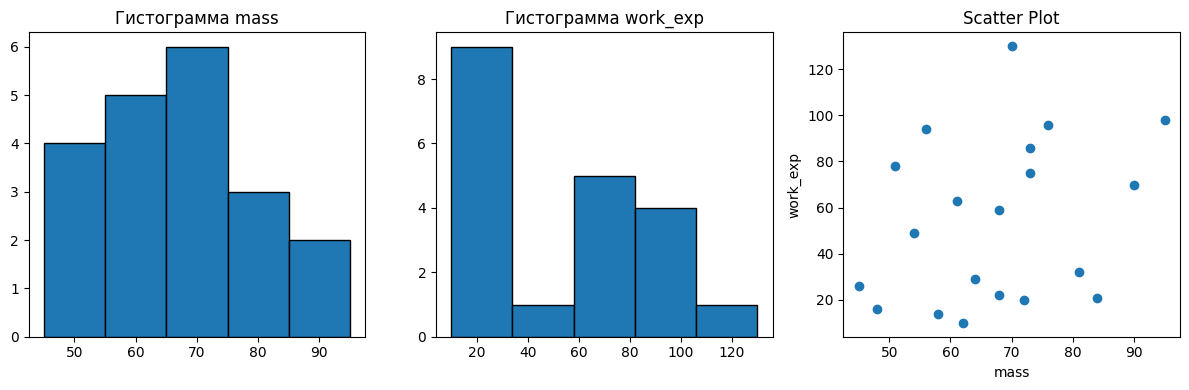

In [4]:
# 2. Визуализация
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x, bins=5, edgecolor='black')
plt.title(f'Гистограмма {col1}')
plt.subplot(1, 3, 2)
plt.hist(y, bins=5, edgecolor='black')
plt.title(f'Гистограмма {col2}')
plt.subplot(1, 3, 3)
plt.scatter(x, y)
plt.xlabel(col1)
plt.ylabel(col2)
plt.title('Scatter Plot')
plt.tight_layout()
plt.show()


Уравнения регрессии:
Линейная: y = 0.75*x + 3.99
Квадратичная: y = 0.0*x^2 + 0.74*x + 4.15
Гиперболическая: y = -3182.98/x + 103.49
Показательная: y = 1.02^x * 13.94


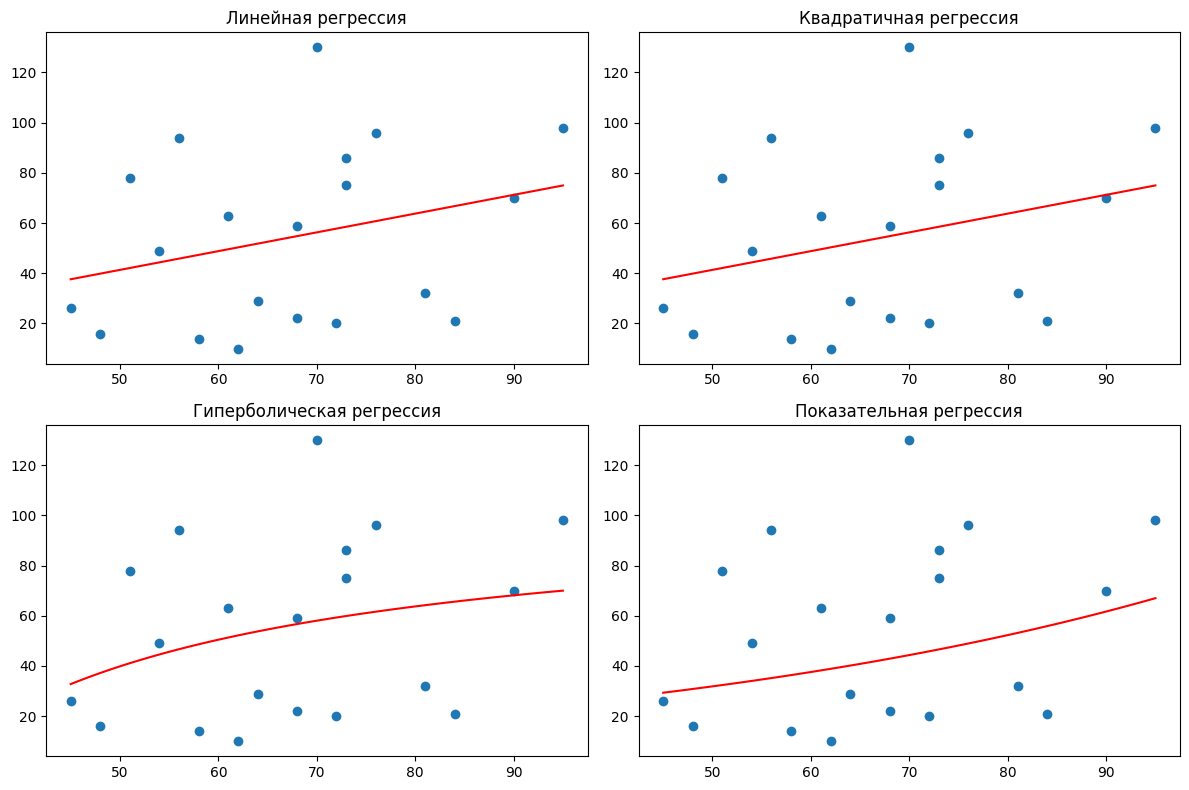

In [5]:
# 3. Уравнения регрессии
def linear_regression(x, y):
    x_mean, y_mean = np.mean(x), np.mean(y)
    w1 = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
    w0 = y_mean - w1 * x_mean
    return w0, w1

def quadratic_regression(x, y):
    X = np.column_stack([x**2, x, np.ones(len(x))])
    coeffs = np.linalg.lstsq(X, y, rcond=None)[0]
    return coeffs[2], coeffs[1], coeffs[0]

def hyperbolic_regression(x, y):
    X = np.column_stack([1/x, np.ones(len(x))])
    coeffs = np.linalg.lstsq(X, y, rcond=None)[0]
    return coeffs[1], coeffs[0]

def exponential_regression(x, y):
    log_y = np.log(y)
    X = np.column_stack([x, np.ones(len(x))])
    coeffs = np.linalg.lstsq(X, log_y, rcond=None)[0]
    w1 = np.exp(coeffs[0])
    w0 = np.exp(coeffs[1])
    return w0, w1

# Построение моделей
w0_lin, w1_lin = linear_regression(x, y)
w0_quad, w1_quad, w2_quad = quadratic_regression(x, y)
w0_hyp, w1_hyp = hyperbolic_regression(x, y)
w0_exp, w1_exp = exponential_regression(x, y)

print("\nУравнения регрессии:")
print(f"Линейная: y = {round(w1_lin, 2)}*x + {round(w0_lin, 2)}")
print(f"Квадратичная: y = {round(w2_quad, 2)}*x^2 + {round(w1_quad, 2)}*x + {round(w0_quad, 2)}")
print(f"Гиперболическая: y = {round(w1_hyp, 2)}/x + {round(w0_hyp, 2)}")
print(f"Показательная: y = {round(w1_exp, 2)}^x * {round(w0_exp, 2)}")

# Визуализация регрессии
plt.figure(figsize=(12, 8))
x_range = np.linspace(min(x), max(x), 100)

plt.subplot(2, 2, 1)
plt.scatter(x, y)
plt.plot(x_range, w1_lin*x_range + w0_lin, color='red')
plt.title('Линейная регрессия')

plt.subplot(2, 2, 2)
plt.scatter(x, y)
plt.plot(x_range, w2_quad*x_range**2 + w1_quad*x_range + w0_quad, color='red')
plt.title('Квадратичная регрессия')

plt.subplot(2, 2, 3)
plt.scatter(x, y)
plt.plot(x_range, w1_hyp/x_range + w0_hyp, color='red')
plt.title('Гиперболическая регрессия')

plt.subplot(2, 2, 4)
plt.scatter(x, y)
plt.plot(x_range, w0_exp * (w1_exp ** x_range), color='red')
plt.title('Показательная регрессия')
plt.tight_layout()
plt.show()

In [6]:
# 4. Проверка критерием Фишера
def fisher_test(y_true, y_pred, k):
    n = len(y_true)
    y_mean = np.mean(y_true)
    ssr = np.sum((y_pred - y_mean)**2)
    sse = np.sum((y_true - y_pred)**2)
    f_value = (ssr / k) / (sse / (n - k - 1))
    p_value = 1 - stats.f.cdf(f_value, k, n - k - 1)
    return f_value, p_value

models = {
    'Линейная': w1_lin*x + w0_lin,
    'Квадратичная': w2_quad*x**2 + w1_quad*x + w0_quad,
    'Гиперболическая': w1_hyp/x + w0_hyp,
    'Показательная': w0_exp * (w1_exp ** x)
}

mse_values = {}
f_values = {}
for name, y_pred in models.items():
    mse = np.mean((y - y_pred)**2)
    mse_values[name] = mse
    k = 1 if name != 'Квадратичная' else 2
    f_value, p_value = fisher_test(y, y_pred, k)
    f_values[name] = (f_value, p_value)

best_model = min(mse_values, key=mse_values.get)
worst_model = max(mse_values, key=mse_values.get)

print(f"\nНаилучшая модель: {best_model} (MSE: {mse_values[best_model]:.2f})")
print(f"Наихудшая модель: {worst_model} (MSE: {mse_values[worst_model]:.2f})")
print(f"F-статистика для {best_model}: {f_values[best_model][0]:.2f}, p-value: {f_values[best_model][1]:.4f}")
print(f"F-статистика для {worst_model}: {f_values[worst_model][0]:.2f}, p-value: {f_values[worst_model][1]:.4f}")



Наилучшая модель: Квадратичная (MSE: 1083.70)
Наихудшая модель: Показательная (MSE: 1202.06)
F-статистика для Квадратичная: 0.77, p-value: 0.4776
F-статистика для Показательная: 3.22, p-value: 0.0897
